***Sharable Link: https://colab.research.google.com/drive/1FkxnOhl6sUztp70GeJW14e2xL5FdbIII***

#1. Download Data and Read

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print('success!')

success!


In [0]:
import torch, pickle, os, sys, random, time
from torch import LongTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim
from collections import *
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


data = {}
f_id = {}

downloaded = drive.CreateFile({'id':"1Pnrn3O4BGENZ04puhim9XGabyn2oOhle"})   # replace the id with id of file you want to access
downloaded.GetContentFile('test.txt')

bertall = drive.CreateFile({'id':"1dPzzN1XvaKkQTgt-uszrj4-Sahcm48Wz"})   # replace the id with id of file you want to access
bertall.GetContentFile('bert_all.txt')

corpus_id = 'https://drive.google.com/file/d/1Lc6gCweOIbu1Vr6ZSgFGUIojlriP--Qu/view?usp=sharing'

data['train'] = {'ip_word': '', 'ip_tone': '', 'ip_pos': '','words': '', 'tones': '',  'poss': ''}
f_id['train'] = {
    'train.ip_word': '1h6KBu562VWsMYJBVaA9IQ4U9I9jWDETF',
    'train.ip_tone': '1jVlF3i2mEQWLISXts8YbMeSSGil6GTUz',
    'train.ip_pos':'18Gc3KBRn7yDAvYx3lyHAFbfpb3mjKvEo',
    'train.words': '1S8fAZXB35u0Hg3ViS6YQoPMK50wb4jaf',
    'train.tones': '13-V4XeMglY78LLTWfdUST7mQP8VC18Ml',
    'train.poss':'1WTlVDEervpea39Gw_5FwWNlCOAnnbMku'
}

data['test'] = {'ip_word': '', 'ip_tone': '', 'ip_pos': '','words': '', 'tones': '', 'poss': ''}
f_id['test'] = {
    'test.ip_word': '1ET0SoLOnoPXBqvcjU84CmexhB1dEFe8w',
    'test.ip_tone': '1-NSftNu0X10R9XJuBNd3-5bbTK4XzbkV',
    'test.ip_pos':'1z7fVZkTddcCcNXMaf8dyaUtjt_Pvqluc',
    'test.words': '1W0uRDwxmQMoPK_i_kMguRIkHyZjZQ_8C',
    'test.tones': '1xIXGjJi89tyG2Lo4MjkUqNHm8OCssO4S',
    'test.poss':'1o2RnbDwL2BgQSiruRZaxmXP7bRpexVtT'
}

data['dev'] = {'ip_word': '', 'ip_tone': '', 'ip_pos': '','words': '', 'tones': '', 'poss': ''}
f_id['dev'] = {
    'dev.ip_word': '1hTGb2dRleGXC4TONjKWT4D-ZLO44ONZ0',
    'dev.ip_tone': '1Hq8AY8M_T0O4bT4pYL9QKudTC1BhsjWY',
    'dev.ip_pos':'1zzW-VGGZhswe4B_1LIaDtBVHh_nmgvX5',
    'dev.words': '11ggXfnE421c0SX5rFYygCdqXA7198k6I',
    'dev.tones': '1CmfmM9W9DnjxHjmr0wVnToGbmoPNSIAT',
    'dev.poss':'1Kxwb9Vbm-psYbsi7nIrfUIiIgpcAb9PZ'
}

In [3]:
for phase in ['train', 'test', 'dev']:

    print(phase)
    for fname in f_id[phase]:
        f = drive.CreateFile({'id' :f_id[phase][fname]})
        f.GetContentFile(fname)
        with open(fname, 'r') as f_prosody:
            name = fname.split('.')[1]
            if name == 'ip_word': 
                data[phase][name] = f_prosody.read().splitlines()
            elif name == 'words':
                data[phase][name] = f_prosody.read().split()
            elif name == 'ip_tone' or name == 'ip_pos':
                data[phase][name] = f_prosody.read().splitlines()
            elif name == 'tones' or name == 'poss':
                data[phase][name] = f_prosody.read().split()

    vocab = list(set(data[phase]['words']))
    pos_vocab = list(set(data[phase]['poss']))

    from prettytable import PrettyTable



    #training set
    print('words : %s ...' % data[phase]['words'][:10])
    print('tunes : %s ...' % data[phase]['tones'][:10])
    print('poss  : %s ...' % data[phase]['poss'][:10])

#    t = PrettyTable(['','0', '1','2','3','4'])
    t = PrettyTable(range(11))
    t.add_row(['ip_word'] + data[phase]['ip_word'][:10])
    t.add_row(['ip_pos'] + data[phase]['ip_pos'][:10])
    t.add_row(['ip_tone'] + data[phase]['ip_tone'][:10])

    print(t)

    print("Number of tokens in %s: %d " % (phase, len(data[phase]['words'])))
    len_ = 0
    for ip in data[phase]['ip_word']:
        len_ += len(ip.split())
    print("Number of ips in %s %d" % (phase, len_))






train
words : ['Under', 'the', 'new', 'law', 'the', 'consequences', 'of', 'driving', 'drunk', 'will'] ...
tunes : ['H+H*', 'O', 'O', 'H*L-H%', 'O', 'H*', 'O', 'L+H*', 'H*L-H%', 'O'] ...
poss  : ['IN', 'DT', 'JJ', 'NN', 'DT', 'NNS', 'IN', 'VBG', 'NN', 'MD'] ...
+---------+-------------------+-----------------------------------+---------------+------------+---------------+-------------------+----------------------+----------------------------+-----------------+--------+
|    0    |         1         |                 2                 |       3       |     4      |       5       |         6         |          7           |             8              |        9        |   10   |
+---------+-------------------+-----------------------------------+---------------+------------+---------------+-------------------+----------------------+----------------------------+-----------------+--------+
| ip_word | Under the new law | the consequences of driving drunk | will be swift | and severe | Under 

#Invalid tone

In [4]:
phase = ['train', 'test', 'dev']

cnt = 0
for k in range(3):
    print("**** %s **** " %phase[k])
    for i in range(len(data[phase[k]]['ip_tone'])):
        lastchar = data[phase[k]]['ip_tone'][i][-1][-1]
        if not (lastchar == '%' or lastchar == '-'):
            cnt += 1
            print(data[phase[k]]['ip_word'][i])
            print(data[phase[k]]['ip_tone'][i])
print(cnt)

**** train **** 
none of them ever went through with it According
H* O O H* O L+H* O O L-L%L*
dig deep
O H*L-L*
or are not available according
O L* L* H* L-L%L*
Wanted Chief
H* L-L%H*
came from the ranks of JNC
H* O O H+H* O L-L+H*
he said
O H+H*H-H*
that year Thomas
H* O H-H*
Battery
H-H*
brth talk about the companys fetal
O H* O O H* L-H*
brth when Johnson Controls instituted
H% O H* H* H-H*L*
dont use existing services school-based
H* H* L+H* O L-H%H*
the state is
O H* H-%H
state officials
H* L+H*H-H*
**** test **** 
the successful effort last election to get the mandatory
O L+H*L+H* L+H*L+H* O L+H*L+H* L+H* O O L-H*
Lynn activist Chip
H* H* L-L%H*
which allows someone to
H* H+H* O H-H*
first time offenders
L+H* O L-H%L+H*
that hooks up
O L+H* L-H%H*
he developed At
H* L+H* H-H*
twelve-hundred
H*H-H*
**** dev **** 
and personal
H* L-L%H*
the description conjures
O H* H-H*
cost effective alternative to
H* H+H* H* L-H%%H
that should not alarm civil
O O L+H* O L-H%H*
libertarians Docto

#2. Build Integer Dictionaries 

In [5]:
#Create dictionary using 'train' data 


vocab = Counter()
pos_vocab = Counter()
tag_map = Counter() 

inv_dict_vocab = {}
inv_dict_pos_vocab = {}
inv_dict_tag = {}

vocab['PAD'] = 0 
pos_vocab['PAD'] = 0
tag_map['PAD'] = 0
vocab['UNK'] = 1 
pos_vocab['UNK'] = 1
tag_map['UNK'] = 1

inv_dict_vocab[0] = 'PAD'
inv_dict_pos_vocab[0] = 'PAD'
inv_dict_tag[0] = 'PAD'

inv_dict_vocab[1] = 'UNK'
inv_dict_pos_vocab[1] = 'UNK'
inv_dict_tag[1] = 'UNK'

i = 2
for w in data['train']['words']:
    if not vocab[w]:
        vocab[w] = i
        inv_dict_vocab[i] = w
        i += 1

k = 2
for w in data['train']['poss']:
    if not pos_vocab[w]:
        pos_vocab[w] = k
        inv_dict_pos_vocab[k] = w
        k += 1

j = 2
for t in data['train']['tones']:
    if not tag_map[t]:
        tag_map[t] = j
        inv_dict_tag[j] = t
        j += 1

print(inv_dict_vocab)
print(inv_dict_pos_vocab)
print(inv_dict_tag)

{0: 'PAD', 1: 'UNK', 2: 'Under', 3: 'the', 4: 'new', 5: 'law', 6: 'consequences', 7: 'of', 8: 'driving', 9: 'drunk', 10: 'will', 11: 'be', 12: 'swift', 13: 'and', 14: 'severe', 15: 'old', 16: 'already', 17: 'tough', 18: 'first', 19: 'time', 20: 'offenders', 21: 'used', 22: 'to', 23: 'lose', 24: 'their', 25: 'license', 26: 'for', 27: 'thirty', 28: 'days', 29: 'Well', 30: 'now', 31: 'they', 32: 'could', 33: 'it', 34: 'as', 35: 'many', 36: 'ninety', 37: 'prison', 38: 'sentence', 39: 'a', 40: 'second', 41: 'offender', 42: 'has', 43: 'doubled', 44: 'is', 45: 'also', 46: 'tougher', 47: 'vehicular', 48: 'homicide', 49: 'cracks', 50: 'down', 51: 'on', 52: 'minors', 53: 'who', 54: 'drink', 55: 'drive', 56: 'State', 57: 'trooper', 58: 'Joseph', 59: 'Holly', 60: 'says', 61: 'this', 62: 'mean', 63: 'fewer', 64: 'drunken', 65: 'drivers', 66: 'What', 67: 'you', 68: 'dont', 69: 'know', 70: 'wont', 71: 'hurt', 72: 'That', 73: 'adage', 74: 'may', 75: 'apply', 76: 'most', 77: 'situations', 78: 'but', 79

#3. Loading the Data

In [6]:
wordList = {}
posList = {}
toneList = {}

seqlen = {'train':[], 'test':[], 'dev':[]}


for phase in ['train', 'test', 'dev']:
    wordList[phase] = []        
    posList[phase] = []
    toneList[phase] = []
    hit = 0
    miss = 0

    len_sent = []
    for sentence in data[phase]['ip_word']:
        seqlen[phase].append(len(sentence.split()))
        s = []
        for token in sentence.split(' '):
            if token in vocab:
                hit += 1
                s.append(vocab[token])
            else:
                miss += 1
                s.append(vocab['UNK'])
#        s = [vocab[token] if token in vocab 
#         else vocab['UNK']
#         for token in sentence.split(' ')]
        wordList[phase].append(s)
        len_sent.append(len(s))
    print('phase: %s' % phase)
    print("hit: %d" % hit)
    print("miss: %d" % miss)

    for pos_phrase in data[phase]['ip_pos']:
        # replace each token by its index if it is in vocab
        # else use index of UNK
        s = [pos_vocab[token] if token in pos_vocab 
            else pos_vocab['UNK']
            for token in pos_phrase.split(' ')]
        posList[phase].append(s)
    
    for tone in data[phase]['ip_tone']:
        splitted_tones = tone.split(' ')
        # replace each label by its index
        l = [tag_map[label] for label in splitted_tones]
        toneList[phase].append(l) 


    print(phase)
    print(data[phase]['ip_word'][:10])
    print(wordList[phase][:10])
    print(data[phase]['ip_pos'][:10])
    print(posList[phase][:10])
    print(data[phase]['ip_tone'][:10])
    print(toneList[phase][:10])

    
    mean = sum(len_sent) / len(len_sent)
    from statistics import stdev
    stdev_val = stdev(len_sent)
    print("mean: %f" % mean)
    print("stdev: %f" % stdev_val)

print(seqlen['train'])
print(len(seqlen['train']))
#    print(seqlen['test'])
#    print(seqlen['dev'])



phase: train
hit: 18483
miss: 2
train
['Under the new law', 'the consequences of driving drunk', 'will be swift', 'and severe', 'Under the old', 'already tough law', 'first time offenders', 'used to lose their license', 'for thirty days', 'Well']
[[2, 3, 4, 5], [3, 6, 7, 8, 9], [10, 11, 12], [13, 14], [2, 3, 15], [16, 17, 5], [18, 19, 20], [21, 22, 23, 24, 25], [26, 27, 28], [29]]
['IN DT JJ NN', 'DT NNS IN VBG NN', 'MD VB JJ', 'CC JJ', 'IN DT JJ', 'RB JJ NN', 'JJ NN NNS', 'VBN TO VB PP$ NN', 'IN CD NNS', 'RB']
[[2, 3, 4, 5], [3, 6, 2, 7, 5], [8, 9, 4], [10, 4], [2, 3, 4], [11, 4, 5], [4, 5, 6], [12, 13, 9, 14, 5], [2, 15, 6], [11]]
['H+H* O O H*L-H%', 'O H* O L+H* H*L-H%', 'O O H*H-', 'H* H*L-L%', 'H* O H-', 'H* H* L-H%', 'H* O H*L-H%', 'H* O H* O L+H*L-', 'O H* H+H*L-L%', 'H*H-H%']
[[2, 3, 3, 4], [3, 5, 3, 6, 4], [3, 3, 7], [5, 8], [5, 3, 9], [5, 5, 10], [5, 3, 4], [5, 3, 5, 3, 11], [3, 5, 12], [13]]
mean: 3.645957
stdev: 1.887416
phase: test
hit: 5336
miss: 634
test
['the state', 'S

#4. Preparing Batches


In [7]:
# compute length of longest sentence in batch

batch_max_len = max([len(s) for s in wordList['train']])
test_batch_max_len = max([len(s) for s in wordList['test']])
dev_batch_max_len = max([len(s) for s in wordList['dev']])
N = max(batch_max_len, test_batch_max_len, dev_batch_max_len)

batches = {}
batches['train'] = {'word':'', 'poss':'', 'labels':''}
batches['test'] = {'word':'', 'poss':'', 'labels':''}
batches['dev'] = {'word':'', 'poss':'', 'labels':''}

for phase in ['train', 'test', 'dev']:

    # prepare a numpy array with the data, initializing the data with 'PAD' 
    # and all labels with -1; initializing labels to -1 differentiates tokens 
    # with tones from 'PAD' tokens
    batches[phase]['words'] = vocab['PAD'] * np.ones((len(wordList[phase]), N))
    batches[phase]['poss'] = pos_vocab['PAD'] * np.ones((len(wordList[phase]), N))
    batches[phase]['labels'] = tag_map['PAD']*np.ones((len(wordList[phase]), N))

    # copy the data to the numpy array
    for j in range(len(wordList[phase])):
        cur_len = len(wordList[phase][j])
        batches[phase]['words'][j][:cur_len] = wordList[phase][j]
        batches[phase]['poss'][j][:cur_len] = posList[phase][j]
        batches[phase]['labels'][j][:cur_len] = toneList[phase][j]

    # since all data are indices, we convert them to torch LongTensors
    batches[phase]['words'] = torch.LongTensor(batches[phase]['words']) 
    batches[phase]['poss'] = torch.LongTensor(batches[phase]['poss']) 
    batches[phase]['labels'] = torch.LongTensor(batches[phase]['labels'])

    seqlen[phase] = torch.LongTensor(seqlen[phase])


    print("Training Batches")
    print(batches[phase]['words'])
    print(batches[phase]['poss'])
    print(batches[phase]['labels'])

    print(batches[phase]['words'].size())
    print(batches[phase]['poss'].size())
    print(batches[phase]['labels'].size())
    print()

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 32 
HIDDEN_DIM = 32

Training Batches
tensor([[   2,    3,    4,  ...,    0,    0,    0],
        [   3,    6,    7,  ...,    0,    0,    0],
        [  10,   11,   12,  ...,    0,    0,    0],
        ...,
        [2359,   61,  481,  ...,    0,    0,    0],
        [  26, 1047,    0,  ...,    0,    0,    0],
        [  61,   44, 3140,  ...,    0,    0,    0]])
tensor([[ 2,  3,  4,  ...,  0,  0,  0],
        [ 3,  6,  2,  ...,  0,  0,  0],
        [ 8,  9,  4,  ...,  0,  0,  0],
        ...,
        [ 8,  9, 18,  ...,  0,  0,  0],
        [ 4,  6,  0,  ...,  0,  0,  0],
        [19, 16, 22,  ...,  0,  0,  0]])
tensor([[ 2,  3,  3,  ...,  0,  0,  0],
        [ 3,  5,  3,  ...,  0,  0,  0],
        [ 3,  3,  7,  ...,  0,  0,  0],
        ...,
        [ 5,  3,  8,  ...,  0,  0,  0],
        [ 3, 70,  0,  ...,  0,  0,  0],
        [ 5,  3,  5,  ...,  0,  0,  0]])
torch.Size([5070, 20])
torch.Size([5070, 20])
torch.Size([5070, 20])

Training Batches
tensor([[   3,  321,    0,  ...,    0,    0,    0],
        [ 

# 5. LSTM Tagger 

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pos_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Additional Embeddings
        self.pos_embeddings = nn.Embedding(pos_size, embedding_dim)


        print("|vocab|" + str(vocab_size))
        print("|pos|"   + str(pos_size))


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence, poss):
#        print(sentence)
#        sys.exit()
        word_embeds = self.word_embeddings(sentence)

#        print(word_embeds)
        #Additional Embeddings
        pos_embeds = self.pos_embeddings(poss)
#        print(pos_embeds)
        sum_embeds = word_embeds + pos_embeds

        lstm_out, _ = self.lstm(word_embeds.view(len(sentence), 1, -1))
        #lstm_out, _ = self.lstm(sum_embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

# 8. Train Model

In [9]:
VOCAB = vocab
POS_VOCAB = pos_vocab

TRAIN_INPUT = batches['train']['words']
TRAIN_POS = batches['train']['poss']
TRAIN_LABEL = batches['train']['labels']

DEV_INPUT = batches['dev']['words']
DEV_POS = batches['dev']['poss'] 
DEV_LABEL = batches['dev']['labels'] 


print(TRAIN_INPUT)

print('Batch size      |N|: %4d' % N)
print('# of vocabulary |V|: %4d' % len(vocab))
print('# of pos        |P|: %4d' % len(pos_vocab))
print('# of labels        : %4d' % len(tag_map))
print('---------------------------')
net = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(VOCAB), len(tag_map), len(POS_VOCAB))

loss_function = nn.NLLLoss(ignore_index=0)
optimizer = optim.SGD(net.parameters(), lr=0.06)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
print('Start Training')
pred = [0] * len(TRAIN_INPUT)
dev_pred = [0] * len(DEV_INPUT)
#with torch.no_grad():
#    pred[0] = net(TRAIN_INPUT[0], TRAIN_POS[0])
#    print(pred[0])

NUM_EPOCH = 5 
progress = 0.0
for epoch in range(NUM_EPOCH):  # again, normally you would NOT do 300 epochs, it is toy data
    #acc = 100 / NUM_EPOCH 
    #progress += acc 
    start_time = time.time()
    #random.shuffle(TRAIN_INPUT)
    # training phase
    sum_train_loss = 0.0
    net.train()  
    for i in range(len(TRAIN_INPUT)):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        net.zero_grad()

        # Step 3. Run our forward pass.
        pred[i] = net(TRAIN_INPUT[i], TRAIN_POS[i])

        # Step 4. Compute the loss, gradients, and update the parmaeters by
        #  calling optimizer.step()
 #       print("pred[i]")
 #       print(pred[i].size())
 #       print("TRAIN_LABEL[i]")
#        print(TRAIN_LABEL[i])
#        sys.exit()
        train_loss = loss_function(pred[i], TRAIN_LABEL[i])
        sum_train_loss += train_loss.data
        train_loss.backward()
        optimizer.step()

    # validation phase
    sum_dev_loss = 0.0
    net.eval()
    for i in range(len(DEV_INPUT)):
        dev_pred[i] = net(DEV_INPUT[i], DEV_POS[i])
        dev_loss = loss_function(dev_pred[i], DEV_LABEL[i])
        sum_dev_loss += dev_loss.data
    print('epoch: %d, train loss: %0.2f, time: %0.2f sec, dev loss: %0.2f' % \
          (epoch, sum_train_loss, time.time()-start_time, sum_dev_loss))

    #print(str(progress) , end='%..')
print('Finished training')
# See what the scores are after training

#with torch.no_grad():
#    pred[0] = net(TRAIN_INPUT[0], TRAIN_POS[0])
#    print(pred[0])
    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    #print(pred[i])

tensor([[   2,    3,    4,  ...,    0,    0,    0],
        [   3,    6,    7,  ...,    0,    0,    0],
        [  10,   11,   12,  ...,    0,    0,    0],
        ...,
        [2359,   61,  481,  ...,    0,    0,    0],
        [  26, 1047,    0,  ...,    0,    0,    0],
        [  61,   44, 3140,  ...,    0,    0,    0]])
Batch size      |N|:   20
# of vocabulary |V|: 3466
# of pos        |P|:   31
# of labels        :  105
---------------------------
|vocab|3466
|pos|31
Start Training
epoch: 0, train loss: 11424.88, time: 22.71 sec, dev loss: 3483.21
epoch: 1, train loss: 10073.69, time: 22.20 sec, dev loss: 3388.11
epoch: 2, train loss: 9689.41, time: 22.46 sec, dev loss: 3347.55
epoch: 3, train loss: 9377.79, time: 22.42 sec, dev loss: 3327.41
epoch: 4, train loss: 9089.84, time: 22.46 sec, dev loss: 3317.25
Finished training


#9. Write prediction and create lstm_all.txt 


In [10]:
TEST_INPUT = batches['test']['words'] 
TEST_INPUT_POS = batches['test']['poss']
TEST_LABEL = batches['test']['labels'] 

INV_DICT_VOCAB = inv_dict_vocab
INV_DICT_POS = inv_dict_pos_vocab
INV_DICT_LABEL = inv_dict_tag

PREDICTION = [0] * len(TEST_INPUT)

word_output = []
pos_output = []
pred_output = []
actual_output = []

prdread = open("test_predictions_lstm.txt","w+")
cnt = 0
for sl in seqlen['test']:
   cnt += sl 
print("cnt %d" % cnt)
with torch.no_grad():
    for i in range(len(TEST_INPUT)):
        pred_tensor = net(TEST_INPUT[i], TEST_INPUT_POS[i])
        for j in range(seqlen['test'][i]):
            idx = pred_tensor[j].argmax().item()
            word = INV_DICT_VOCAB[TEST_INPUT[i][j].item()]
            pr = INV_DICT_LABEL[idx]
            prdread.write(word + " " + pr + "\n")
        prdread.write("\n")


prdread.close()
gtfile = open("test.txt","r")
prdfile = open("test_predictions_lstm.txt","r")

all_symbol = open("lstm_all.txt", "w+")
pitch = open("lstm_pitch.txt", "w+")
phr = open("lstm_phr.txt", "w+")
bnd = open("lstm_bnd.txt", "w+")

# gt = gtfile.readlines()
# prd = prdfile.readlines()
gt = gtfile.read().splitlines()
prd = prdfile.read().splitlines()


print(len(gt))
print(len(prd))
# sys.exit()
assert(len(gt) == len(prd))
for i in range(len(prd)):
#    print(i)
    if gt[i].strip() and prd[i].strip():
        gtline = gt[i].split()
        word = gtline[0]
        gtlabel = gtline[1]
        gtpitch = ''
        gtphr = ''
        gtbnd = ''
        if gtlabel != 'O':
            gtlabel = 'B-' + gtlabel
        
        if '*' in gtlabel:
            gtpitch = 'B-*'
        else:
            gtpitch = 'O'
        if '-' in gtlabel:
            gtphr = 'B--'
        else:
            gtphr = 'O'
        if '%' in gtlabel:
            gtbnd = 'B-%'
        else:
            gtbnd = 'O'

        prdline = prd[i].split()
        prdlabel = prdline[1]
        prdpitch = ''
        prdphr = ''
        prdbnd = ''
        if prdlabel != 'O':
            prdlabel = 'B-' + prdlabel

        
        if '*' in prdlabel:
            prdpitch = 'B-*'
        else:
            prdpitch = 'O'
        if '-' in prdlabel:
            prdphr = 'B--'
        else:
            prdphr = 'O'
        if '%' in prdlabel:
            prdbnd = 'B-%'
        else:
            prdbnd = 'O'
        
        all_symbol.write( word + ' ' + gtlabel+ ' ' + prdlabel + '\n')
        pitch.write( word + ' ' + gtpitch+ ' ' + prdpitch + '\n')
        phr.write( word + ' ' + gtphr+ ' ' + prdphr + '\n')
        bnd.write( word + ' ' + gtbnd+ ' ' + prdbnd + '\n')
    else:
        all_symbol.write('\n')
        pitch.write('\n')
        phr.write('\n')
        bnd.write('\n')


gtfile.close()
prdfile.close()

all_symbol.close()
pitch.close()
phr.close()
bnd.close()

cnt 5970
7675
7675


#Test Model


LSTM result
lendata 5970
lentrueseqs 5970
HERE 0
processed 5970 words with 3397 ToBI symbols; found: 3048 ToBI symbols; correct: 887.
accuracy:  26.11%; (non-O)
accuracy:  50.82%; precision:  29.10%; recall:  26.11%; FB1:  27.53
['H*', 'H*L-L%', 'L-H%', 'H*H-', 'L-L%', 'H*L-H%', 'H*H*L-L%', 'H-']
               H*: precision:  35.78%; recall:  60.90%; FB1:  45.07  1976
           H*L-L%: precision:  17.33%; recall:  30.77%; FB1:  22.17  600
             L-H%: precision:  13.42%; recall:  21.53%; FB1:  16.53  231
             H*H-: precision:  20.47%; recall:  15.02%; FB1:  17.33  171
             L-L%: precision:  22.58%; recall:   4.86%; FB1:   8.00  31
           H*L-H%: precision:   3.45%; recall:   0.60%; FB1:   1.02  29
         H*H*L-L%: precision:  28.57%; recall:  22.22%; FB1:  25.00  7
               H-: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
               %H: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             H*H*: precision:   0.00%; recall:   0.0

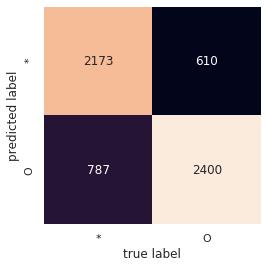

processed 5970 words with 2960 ToBI symbols; found: 2783 ToBI symbols; correct: 2173.
accuracy:  73.41%; (non-O)
accuracy:  76.60%; precision:  78.08%; recall:  73.41%; FB1:  75.67
['*']
                *: precision:  78.08%; recall:  73.41%; FB1:  75.67  2783
HERE 2


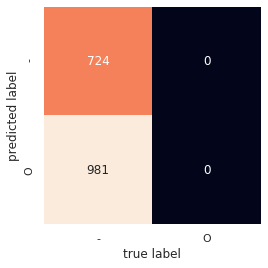

processed 1705 words with 1705 ToBI symbols; found: 724 ToBI symbols; correct: 724.
accuracy:  42.46%; (non-O)
accuracy:  42.46%; precision: 100.00%; recall:  42.46%; FB1:  59.61
['-']
                -: precision: 100.00%; recall:  42.46%; FB1:  59.61  724
HERE 3


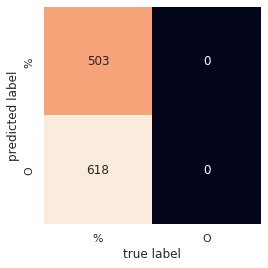

processed 1121 words with 1121 ToBI symbols; found: 503 ToBI symbols; correct: 503.
accuracy:  44.87%; (non-O)
accuracy:  44.87%; precision: 100.00%; recall:  44.87%; FB1:  61.95
['%']
                %: precision: 100.00%; recall:  44.87%; FB1:  61.95  503

--------------------------------------------------
BERT result
lendata 5970
lentrueseqs 5970
HERE 0
processed 5970 words with 3397 ToBI symbols; found: 3304 ToBI symbols; correct: 1325.
accuracy:  39.01%; (non-O)
accuracy:  59.35%; precision:  40.10%; recall:  39.01%; FB1:  39.55
['H*', 'H*L-L%', 'H*H-', 'L+H*', 'L-L%', 'L-H%', 'H*L-H%', 'H-', 'L+H*L-L%', 'H*L-', 'H*H*', 'L+H*L-H%', 'L+H*H-', 'H+H*', 'H*H*L-L%', 'H*H*H-', 'L+H*L-']
               H*: precision:  56.76%; recall:  61.84%; FB1:  59.19  1265
           H*L-L%: precision:  35.35%; recall:  55.33%; FB1:  43.14  529
             H*H-: precision:  36.95%; recall:  54.08%; FB1:  43.90  341
             L+H*: precision:  31.40%; recall:  23.90%; FB1:  27.14  293
            

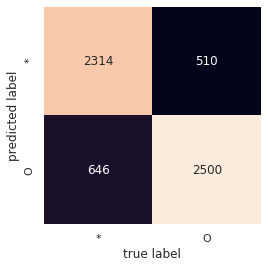

processed 5970 words with 2960 ToBI symbols; found: 2824 ToBI symbols; correct: 2314.
accuracy:  78.18%; (non-O)
accuracy:  80.64%; precision:  81.94%; recall:  78.18%; FB1:  80.01
['*']
                *: precision:  81.94%; recall:  78.18%; FB1:  80.01  2824
HERE 2


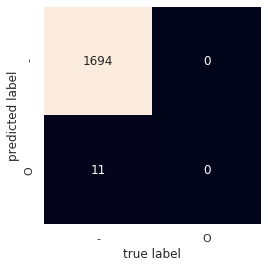

processed 1705 words with 1705 ToBI symbols; found: 1694 ToBI symbols; correct: 1694.
accuracy:  99.35%; (non-O)
accuracy:  99.35%; precision: 100.00%; recall:  99.35%; FB1:  99.68
['-']
                -: precision: 100.00%; recall:  99.35%; FB1:  99.68  1694
HERE 3


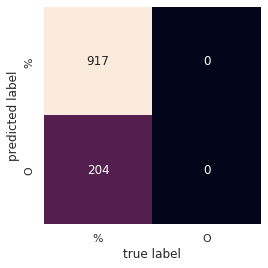

processed 1121 words with 1121 ToBI symbols; found: 917 ToBI symbols; correct: 917.
accuracy:  81.80%; (non-O)
accuracy:  81.80%; precision: 100.00%; recall:  81.80%; FB1:  89.99
['%']
                %: precision: 100.00%; recall:  81.80%; FB1:  89.99  917


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

"""
Original source:
https://github.com/sighsmile/conlleval/blob/master/conlleval.py


This script applies to IOB2 or IOBES tagging scheme.
If you are using a different scheme, please convert to IOB2 or IOBES.

IOB2:
- B = begin, 
- I = inside but not the first, 
- O = outside

e.g. 
John   lives in New   York  City  .
B-PER  O     O  B-LOC I-LOC I-LOC O

IOBES:
- B = begin, 
- E = end, 
- S = singleton, 
- I = inside but not the first or the last, 
- O = outside

e.g.
John   lives in New   York  City  .
S-PER  O     O  B-LOC I-LOC E-LOC O

prefix: IOBES
chunk_type: PER, LOC, etc.
"""
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split('-', maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True

    Note: in case of contradicting tones, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tones
    pred_seqs: a list of predicted tones

    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type

    correct_counts, true_counts, pred_counts: similar to above, but for tones
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    """
    if verbose, print overall performance, as well as preformance per chunk type;
    otherwise, simply return overall prec, rec, f1 scores
    """
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    # print("true_chunks:")
    # for w in sorted(true_chunks, key=true_chunks.get, reverse=True):
    #     print(w, true_chunks[w])

    # print("pred_chunks:")
    # for w in sorted(pred_chunks, key=pred_chunks.get, reverse=True):
    #     print(w, pred_chunks[w])


    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i words with %i ToBI symbols; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i ToBI symbols; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
        
    print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
    print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
    print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))



    sorted_chunk_types = []
    s_chunk_types = []
    sorted_chunk_types.extend(sorted(pred_chunks.items(), key = lambda kv:(kv[1], kv[0]), reverse = True))
    for kv in sorted_chunk_types:
        s_chunk_types.append(kv[0])

    
    print(s_chunk_types)
    for t in chunk_types:
        if t not in s_chunk_types:
            s_chunk_types.append(t)


    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in sorted_chunk_types: 
    #for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])

    return res
    # you can generate LaTeX output for tables like in
    # http://cnts.uia.ac.be/conll2003/ner/example.tex
    # but I'm not implementing this

def evaluate(true_seqs, pred_seqs, verbose=True):
# for boundary detection
    lenTrue = len(true_seqs)
    lenPred = len(pred_seqs)
    trueArr = [[] for y in range(4)]
    predArr = [[] for y in range(4)]

    trueArr[0] = true_seqs
    predArr[0] = pred_seqs

# 1. pitch detection(*)
    for i in range(len(true_seqs)):
        if '*' in true_seqs[i]:
            trueArr[1].append('B-*')
        else: 
            trueArr[1].append('O')

    for i in range(len(pred_seqs)):
        if '*' in pred_seqs[i]: 
            predArr[1].append('B-*')
        else: 
            predArr[1].append('O')


    print("lendata %d" % len(data['test']['words']))
    print("lentrueseqs %d" % len(true_seqs))
# 2. ip boundary detection(-)
    for i in range(len(true_seqs)):
        if true_seqs[i].count('-') >= 2:
            trueArr[2].append('B--')
            if pred_seqs[i].count('-') >= 2:
                predArr[2].append('B--')
            else:
                predArr[2].append('O')

                # print("Expected ip boundary, Prediction: %s" % pred_seqs[i])
                # start = i - 5
                # end = i + 5
                # start = 0 if start < 0 else start 
                # end = len(true_seqs) if end > len(true_seqs) else end 
                # for k in range(start,end):
                #     if k == i:
                #         print("[", end='')
                #     print(data['test']['words'][k], end=' ')
                #     if k == i:
                #         print("]", end=' ')
                # print()
                # for k in range(start,end):
                #     if k == i:
                #         print("[", end='')
                #     print(data['test']['tones'][k], end=' ')
                #     if k == i:
                #         print("]", end=' ')
                # print()
# 3. IP boundary detection(%)
    for i in range(len(true_seqs)):
        if '%' in true_seqs[i]:
            trueArr[3].append('B-%')
            if '%' in pred_seqs[i]:
                predArr[3].append('B-%')
            else:
                predArr[3].append('O')
                #print("Expected IP boundary:  Prediction: %s" % pred_seqs[i])

    positive = 0
    negative = 0
    false_positive = 0
    false_negative = 0
    etc = 0

    result = [0] * 4
    TARGET_SYMBOL = [' ', '*', '-', '%']
    TARGET_CONLL = [' ', 'B-*', 'B--', 'B-%']
# Detect pitch accent, phrasal tone, or boundary tone
    for k in range(4):
        print("HERE %d" % k)
        true_seqs = trueArr[k]
        pred_seqs = predArr[k]
    
        if k != 0:
            for i in range(len(true_seqs)):
                if true_seqs[i]==TARGET_CONLL[k] and pred_seqs[i] ==TARGET_CONLL[k]:
                    positive += 1
                elif true_seqs[i] == TARGET_CONLL[k] and pred_seqs[i] == 'O':
                    false_negative += 1
                elif true_seqs[i] == 'O' and pred_seqs[i] == 'O':
                    negative += 1
                elif true_seqs[i] == 'O' and pred_seqs[i] == TARGET_CONLL[k]:
                    false_positive += 1
                else:
                    etc += 1
            mat = confusion_matrix(true_seqs, pred_seqs)
            sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=[TARGET_SYMBOL[k],'O'], yticklabels=[TARGET_SYMBOL[k],'O'])
            plt.xlabel('true label')
            plt.ylabel('predicted label');
            plt.show()
    
        (correct_chunks, true_chunks, pred_chunks,
            correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
        result[k] = get_result(correct_chunks, true_chunks, pred_chunks,
            correct_counts, true_counts, pred_counts, verbose=verbose)
    return result 

def evaluate_conll_file(fileIterator):
    true_seqs, pred_seqs = [], []
    
    for line in fileIterator:
        cols = line.strip().split()
        # each non-empty line must contain >= 3 columns
        if not cols:
            pass
            # We do not count new new line.
            #true_seqs.append('O')
            #pred_seqs.append('O')
        elif len(cols) < 3:
            raise IOError("conlleval: too few columns in line %s\n" % line)
        else:
            # extract tones from last 2 columns
            true_seqs.append(cols[-2])
            pred_seqs.append(cols[-1])
    return evaluate(true_seqs, pred_seqs)

if __name__ == '__main__':
    """
    usage:     conlleval < file
    """

    print("LSTM result")
    with open('lstm_all.txt','r') as sys.stdin:
        evaluate_conll_file(sys.stdin)

    print("\n--------------------------------------------------\nBERT result")
    with open('bert_all.txt','r') as sys.stdin:
        evaluate_conll_file(sys.stdin)

#Inference


In [12]:

#sentence = "Mariana made a Marmalade"
#sentence = "What is your name?"
#pos = "A B C D"

#sentence = "He eat the banana"
#sentence = "Did he eat the banana"
#pos = "A B C D E"


sentence = "It was George that ate the banana"
pos = "A B C D E F G"


#sentence = "George ate the banana"
#pos = "A B C D"



length = len(sentence.split())

myWords = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
myPoss = [pos_vocab[token] if token in pos_vocab else pos_vocab['UNK'] for token in pos.split(' ')]

word_batch = vocab['PAD'] * np.ones(N)
pos_batch = pos_vocab['PAD'] * np.ones(N)

cur_len = len(myWords)
word_batch[:cur_len] = myWords 
pos_batch[:cur_len] = myPoss 

word_batch = torch.LongTensor(word_batch)  
pos_batch = torch.LongTensor(pos_batch) 


#print(word_batch.size())
#print(pos_batch.size())
#print(word_batch)
#print(pos_batch)
predictions = []
with torch.no_grad():
    custom_pred = net(word_batch, pos_batch)
#    custom_pred = net(word_batch, length)
    for i in range(length):
        argMax = custom_pred[i].argmax().item()
        target = INV_DICT_LABEL[argMax]
        predictions.append(target)
for i in range(length):
    print("%10s" % sentence.split()[i], end= ' ')
print()
for i in range(length):
    print("%10s" % predictions[i], end = ' ')

        It        was     George       that        ate        the     banana 
         O          O       H*H-          O         H*          O         H* 